# Create models and search against human proteins in Swissprot

## PSI-BLAST

Create PSSM

In [1]:
%%bash
psiblast -subject ../../data/BLAST_uniref90.fasta \
         -in_msa ../../data/msa_edited.fasta \
         -out_pssm ../../models/profile.pssm > /dev/null

Search usign this model

In [2]:
%%bash
rm ../../results/psiblast_search.txt
psiblast -in_pssm ../../models/profile.pssm -db ../../data/SwissProt_humans_reference_all.fasta \
         -outfmt 6 -num_iterations 4 -evalue 0.01 > ../../results/psiblast_search.txt

Read sequences and SH2 domain positions found by psi-blast

In [3]:
from parsers import parsePsiBlastOutput

psiblast_sh2_positions = parsePsiBlastOutput("../../results/psiblast_search.txt")
psiblast_sh2_positions['P16885']

92 sequences found with psi-blast


[{'start': 532, 'end': 623}, {'start': 645, 'end': 725}]

## HMM

Build HMM model

In [4]:
%%bash
hmmbuild ../../models/hmm_model.hmm  ../../data/msa_edited.fasta

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.2.1 (June 2018); http://hmmer.org/
# Copyright (C) 2018 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             ../../data/msa_edited.fasta
# output HMM file:                  ../../models/hmm_model.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     msa_edited             246    99    99     0.87  0.590 

# CPU time: 0.08u 0.00s 00:00:00.08 Elapsed: 00:00:00.09


Search using this model

In [5]:
%%bash
hmmsearch --domtblout ../../results/hmmsearch.hmmer_domtblout \
          ../../models/hmm_model.hmm \
          ../../data/SwissProt_humans_reference_all.fasta > ../../results/hmmsearch_results.hmmer_align

Read sequences and SH2 domain positions found by HMMER

In [6]:
from parsers import parseHmmerOutput

hmm_sh2_positions = parseHmmerOutput("../../results/hmmsearch.hmmer_domtblout")

15 sequences found with hmm-search


In [7]:
# not found!
# hmm_sh2_positions['P16885']

# Jack the hammer

In [8]:
%%bash
jackhmmer --domtblout ../../results/jackhmmsearch.hmmer_domtblout -N 4 --incE 0.01 \
          ../../data/sequenceP23615.fasta \
          ../../data/SwissProt_humans_reference_all.fasta \
          > ../../results/jackhmmsearch_results.hmmer_align

In [9]:
jackhmm_sh2_positions = parseHmmerOutput("../../results/jackhmmsearch.hmmer_domtblout")

109 sequences found with hmm-search


In [10]:
jackhmm_sh2_positions['P16885']

[{'start': 540, 'end': 617}, {'start': 647, 'end': 720}]

# Evaluate Models

In [11]:
from Bio import SeqIO
import math
import json

### Read reference sequences containing SH2 domain (pf00017)

Downloaded from UniProt with the query 

`database:(type:pfam pf00017) AND reviewed:yes AND organism:"Homo sapiens (Human) [9606]`

In [12]:
human_sh2 = SeqIO.parse('../../data/SwissProt_humans_reference.fasta','fasta')

list_human_sh2 = []
for sequence in human_sh2:
    name = sequence.id # name is in the form sp|P46108|CRK_HUMAN
    list_human_sh2.append(name.split('|')[1])

set_human_sh2 = set(list_human_sh2)
print("There are {} human proteins containing SH2 domain in SwissProt".format(len(list_human_sh2)))

There are 100 human proteins containing SH2 domain in SwissProt


### Check all human sequences in SwissProt

Downloaded from UniProt with the query

`reviewed:yes AND organism:"Homo sapiens (Human) [9606]`

In [13]:
human = SeqIO.parse('../../data/SwissProt_humans_reference_all.fasta', 'fasta')

list_human = []
for sequence in human:
    name = sequence.id # name is in the form sp|P46108|CRK_HUMAN
    list_human.append(name.split('|')[1])

num_humans = len(list_human)
print("There are {} human proteins in SwissProt".format(num_humans))

There are 20367 human proteins in SwissProt


Sanity check: all proteins containing SH2 domain should be in this dataset 

In [14]:
assert len(set(list_human).intersection(set_human_sh2)) == len(list_human_sh2)

### Read reference for position

This file can be downloaded from InterPro:

http://www.ebi.ac.uk/interpro/entry/pfam/PF00017/protein/reviewed/?search=Human%20#table

In the dictionary we will save also sequence length. This will be used to compute metrics later.

In [15]:
with open("../../data/interpo-PF00017.json", "r") as file:
    interpro_data = json.load(file)
    
reference_sh2_positions = {}
for el in interpro_data:
    name = el['metadata']['accession']
    length = el['metadata']['length']
    if name in reference_sh2_positions:
        print("{} already in reference dict!".format(name))
        continue
    else:
        reference_sh2_positions[name] = {'length':length, 'positions':[]}
    entries = el['entries']
    for entry in entries:
        if entry['accession']=='PF00017':
            domain_locations = entry['entry_protein_locations']
            for location in domain_locations:
                if len(location['fragments'])>1:
                    print("len fragments > 1")
                position_dict = {
                    'start': location['fragments'][0]['start'],
                    'end': location['fragments'][0]['end']
                }
                reference_sh2_positions[name]['positions'].append(position_dict)

In [16]:
reference_sh2_positions['P16885']

{'length': 1265,
 'positions': [{'start': 532, 'end': 617}, {'start': 646, 'end': 720}]}

## Evaluate ability of retrieving proteins with SH2 domain

In [17]:
from utils import evaluateSequencesSH2

In [18]:
# Evaluate PSI-BLAST
print("Evaluation of psiblast:")
metrics_psiblast = evaluateSequencesSH2(
    psiblast_sh2_positions, set_human_sh2, num_humans
)

Evaluation of psiblast:
	*Accuracy: 1.00
	*Precision: 0.99
	*Sensitivity: 0.91
	*Specificity: 1.00
	*F1 score: 0.95
	*MCC: 0.95



In [19]:
# Evaluate HMM
print("Evaluation of hmmer:")
metrics_hmmer = evaluateSequencesSH2(
    hmm_sh2_positions, set_human_sh2, num_humans
)

Evaluation of hmmer:
	*Accuracy: 1.00
	*Precision: 0.93
	*Sensitivity: 0.14
	*Specificity: 1.00
	*F1 score: 0.24
	*MCC: 0.36



In [20]:
# evaluate jackhmmer
print("Evaluation od jackhmmer:")
metrics_jackhmmer = evaluateSequencesSH2(
    jackhmm_sh2_positions, set_human_sh2, num_humans
)

Evaluation od jackhmmer:
	*Accuracy: 1.00
	*Precision: 0.92
	*Sensitivity: 1.00
	*Specificity: 1.00
	*F1 score: 0.96
	*MCC: 0.96



In [21]:
import pandas as pd
import numpy as np 

list_metrics = ['Precision', 'Sensitivity', 'Specificity', 'F1-score']
results_psiblast = [metrics_psiblast[metric] for metric in list_metrics]
results_hmmer = [metrics_hmmer[metric] for metric in list_metrics]
results_jackhmmer = [metrics_jackhmmer[metric] for metric in list_metrics]

# create dataframe of results
cols = np.c_[results_psiblast,results_hmmer,results_jackhmmer, list_metrics]
res_df = pd.DataFrame(
    cols,
    columns=['psi-blast', 'hmmer', 'jackhmmer', 'metric']
)
sns_df = pd.melt(res_df, value_name='score', var_name='model',
        value_vars=['psi-blast', 'hmmer', 'jackhmmer'], 
        id_vars=['metric']
       )

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
#sns.set_palette("muted")
plt.rcdefaults()

fig = plt.figure(figsize=(8,5))
sns.barplot(x="metric", y="score", hue="model", data=sns_df)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='upper center', ncol=3)
plt.xlabel("")
plt.savefig("../../figures/SequenceEvaluation.pdf")
plt.tight_layout()
plt.show()

<Figure size 800x500 with 1 Axes>

## Evaluate ability of matching domains

In [23]:
#                                        SH2                                SH2
#reference (truth):              |||||||||||||||||||||             |||||||||||||||||||||||||
#model (predicted):    /////    |||||||||||||||||||||||        ||||||||||||||||

In [24]:
from utils import evaluatePositionsSH2

In [25]:
# evaluate psiblast
metrics_psiblast, score_sequence_psiblast = evaluatePositionsSH2(
    psiblast_sh2_positions, reference_sh2_positions
)

	*Accuracy: 0.98
	*Precision: 0.89
	*Sensitivity: 0.98
	*Specificity: 0.98
	*F1 score: 0.93
	*MCC: 0.92



In [26]:
# evaluate jackhammer
metrics_jackhmmer, score_sequence_jackhmmer = evaluatePositionsSH2(
    jackhmm_sh2_positions, reference_sh2_positions
)

	*Accuracy: 0.98
	*Precision: 0.91
	*Sensitivity: 0.94
	*Specificity: 0.98
	*F1 score: 0.92
	*MCC: 0.91



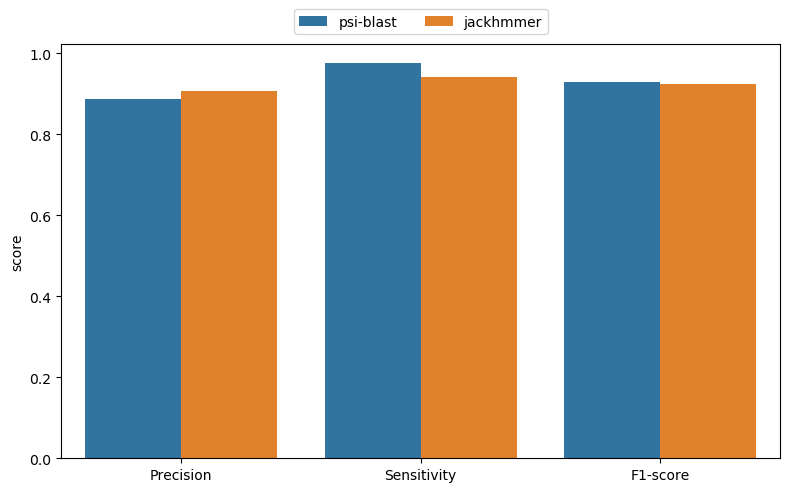

In [27]:
## Global metrics

list_metrics = ['Precision', 'Sensitivity', 'F1-score']
results_psiblast = [metrics_psiblast[metric] for metric in list_metrics]
results_jackhmmer = [metrics_jackhmmer[metric] for metric in list_metrics]

# create dataframe of results
cols = np.c_[results_psiblast,results_jackhmmer, list_metrics]
res_df = pd.DataFrame(
    cols,
    columns=['psi-blast', 'jackhmmer', 'metric']
)
sns_df = pd.melt(res_df, value_name='score', var_name='model',
        value_vars=['psi-blast', 'jackhmmer'], 
        id_vars=['metric']
       )

plt.rcdefaults()

fig = plt.figure(figsize=(8,5))
sns.barplot(x="metric", y="score", hue="model", data=sns_df)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='upper center', ncol=3)
plt.xlabel("")
plt.savefig("../../figures/DomainEvaluation_global.pdf")
plt.tight_layout()
plt.show()

In [28]:
## per squence metrics

models_results = [score_sequence_psiblast, score_sequence_jackhmmer]
model_names = ['psi-blast', 'jackhmmer']

df_results = pd.DataFrame(columns=['score', 'metric', 'model'])

for name, results in zip(model_names, models_results):
    
    for metric in ['Precision', 'Sensitivity', 'F1-score']:
        score  = [res_seq[metric] for res_seq in results]
        df_tmp = pd.DataFrame({
            "score": score,
            "metric": [metric]*len(score),
            "model": [name]*len(score)
        })
        
        df_results = df_results.append(df_tmp, ignore_index=True)      

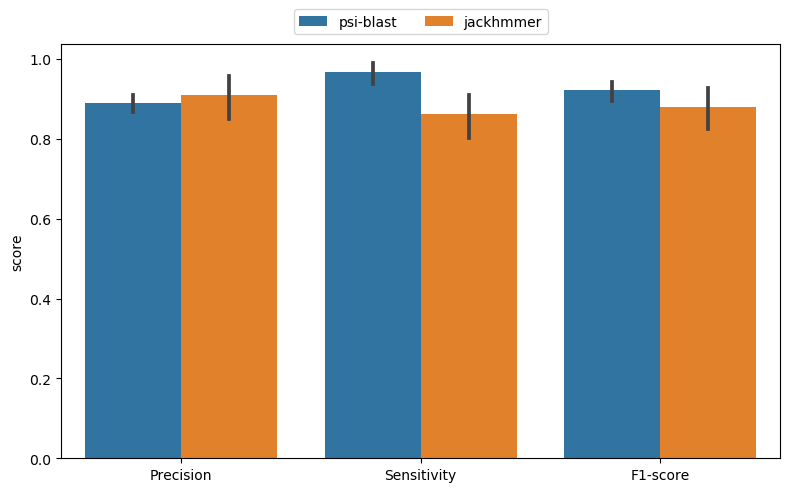

In [29]:
fig = plt.figure(figsize=(8,5))
sns.barplot(x="metric", y="score", hue="model", data=df_results)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='upper center', ncol=3)
plt.xlabel("")
plt.savefig("../../figures/DomainEvaluation_sequence.pdf")
plt.tight_layout()
plt.show()